In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
train_good_imgs = load_img_dict('../dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('../dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('../dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('../dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('../dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('../dataset_pruning/val_border_dict.json')

In [4]:
import csv
import os

from tensorflow.data import Dataset
from tensorflow.io import serialize_tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import is_sparse

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def create_tracking_example(image):
    # At some point might need to consider having reconstruction image
    #define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image))
    }
    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    
    return out

In [5]:
from skimage.exposure import rescale_intensity

def norm(X, size):
    X_norm = histogram_normalization(X, kernel_size=size)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [6]:
def write_tracking_dataset_to_tfr(track, filename, good_imgs):
    app_type = track.appearances.dtype
    app = norm(track.appearances, 64).astype(app_type)
    print('Done calculating normalizations.')
    filename = "/data/tf_records/" + filename + ".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    for b in range(app.shape[0]):
        print(b)
        for f in range(app.shape[1]):
            for c in range(app.shape[2]):
                if good_imgs[b][c][f] != -1:
                    current_image = app[b, f, c]

                    out = create_tracking_example(current_image)

                    if out is not None:
                        writer.write(out.SerializeToString())
                        count += 1

    writer.close()
    print(f'Wrote {count} elements to TFRecord')
    return count

In [7]:
train_trks = load_trks(os.path.join('/training/tracking-nuclear', 'train.trks'))
# val_trks = load_trks(os.path.join('/training/tracking-nuclear', 'val.trks'))

In [12]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')
    
    print('Done creating Track objects.')

    write_tracking_dataset_to_tfr(val_tracks, filename='val_big', good_imgs=val_good_imgs)

100%|███████████████████████████████████████████| 27/27 [02:18<00:00,  5.15s/it]
2022-08-13 04:47:52.477134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1060745520 exceeds 10% of free system memory.


Done creating Track objects.
Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Wrote 89436 elements to TFRecord


In [ ]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')
    
    print('Done with creating Track objects')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_big', good_imgs=train_good_imgs)

2022-08-13 08:48:37.344484: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 08:48:38.630069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1
 33%|██████████████▏                            | 30/91 [05:46<13:02, 12.83s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / 

Done with creating Track objects


In [ ]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [ ]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
val_dataset = get_dataset("/data/tf_records/val_small.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_small.tfrecords", batch_size=100)

In [ ]:
for sample in val_dataset.take(895):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized?')

for sample in train_dataset.take(3838):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized?')

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
vae = VAE(1024, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()

In [ ]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 10
model_path = '/deepcell_data/users/manav/summer_2022/models/big_img_4_layers'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

In [ ]:
x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [47]:
def get_labels_col(lst_idx_to_pos, life_cycle_dict):
    labels_col = []
    for idx in lst_idx_to_pos.keys():
        pos = lst_idx_to_pos[idx]
        labels_col.append(life_cycle_dict[pos[0]][pos[2]][pos[1]])
    return labels_col

train_labels_col = get_labels_col(train_lst_idx_to_pos, train_life_cycle_dict)
val_labels_col = get_labels_col(val_lst_idx_to_pos, val_life_cycle_dict)

In [54]:
import pandas as pd
from keras import backend as K

def get_embedding_distr(img, encoder):
    z_params = encoder.get_layer('z_params')
    inp = encoder.input
    out = z_params.output
    func = K.function([inp], [out])
    x = np.array([img])
    z = func([x])
    return z[0][0]

# Gets embeddings of each array (train, val) along with frame classes
# We want to use train_tracks.appearances (shape (batches, frames, cells))
def get_embeddings_df(app, encoder, embedding_dim, good_imgs, labels_col):
    embeddings_lst = []
    batches, frames, cells = app.shape[:3]
    for b in range(batches):
        print(b)
        for f in range(frames):
            for c in range(cells):
                if good_imgs[b][c][f] != -1:
                    img = app[b][f][c]
                    embedding_distr = get_embedding_distr(img, encoder)
                    label = labels_col[good_imgs[b][c][f]]
                    embeddings_lst.append(np.append(embedding_distr, label))

    cols = [idx for idx in range(2 * embedding_dim)]
    cols.append('Cycle')
    embeddings_df = pd.DataFrame(embeddings_lst, columns=cols)
    return embeddings_df

In [55]:
encoder = vae.encoder_z()
embeddings_df = get_embeddings_df(train_tracks.appearances, encoder, 1024, train_good_imgs, train_labels_col)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [60]:
def project_embeddings_tsne(embeddings_df, tsne):
    just_embeddings_df = embeddings_df.drop('Cycle', axis=1)
    neighbors_embeddings = tsne.fit_transform(just_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, embeddings_df[['Cycle']]], axis = 1)
                          
    return final_df

In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [61]:
%%time
embeddings_tsne_df = project_embeddings_tsne(embeddings_df, tsne)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 15h 1min 14s, sys: 0 ns, total: 15h 1min 14s
Wall time: 50min 18s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


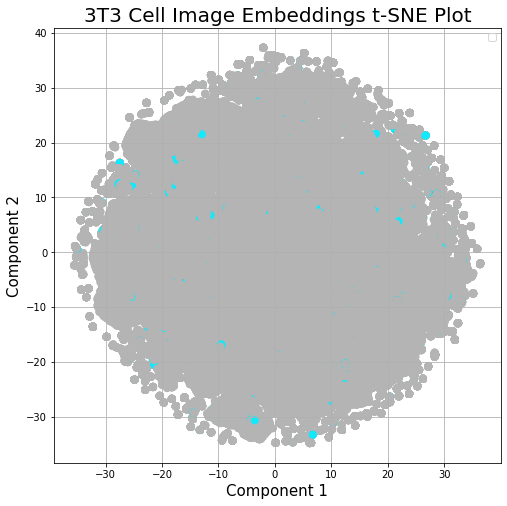

In [63]:
import matplotlib.pyplot as plt

colors = []
for stage in embeddings_tsne_df['Cycle']:
    if stage >= 0 and stage <=5:
        colors.append((18 / 255, 233 / 255, 252 / 255))
    else:
        colors.append((180 / 255, 180 / 255, 180 / 255))
        

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(embeddings_tsne_df['component 1'], embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()